In [26]:
import pandas as pd
from pandas import DataFrame as df
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math
import statsmodels.api as sm 

from sklearn.metrics import accuracy_score
from itertools import combinations
from sklearn.base import clone
from sklearn.metrics import SCORERS

from scipy.stats import chi2_contingency
from scipy.stats import chi2
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

In [4]:
swiggyToDataSet = pd.read_excel("Temp2.xlsx")
swiggyToDataSet.head()

,Distance,Status,Cost,Discount,Surge charges,Tip,PureVeg,Rating,MinutesToDeliver,PromoCode_BF,PromoCode_PRO,PaymentMode_COD,PaymentMode_WALLET,Membership_BING,Membership_BONG,Membership_NO
0,3,1,300,50,0,0,1,2,60,0,1,1,0,1,0,0
1,3,1,100,0,0,5,0,4,20,1,0,0,1,0,1,0
2,6,0,250,25,10,5,1,0,30,0,1,0,0,1,0,0
3,4,1,550,0,10,0,0,1,95,0,1,1,0,0,0,1
4,3,0,125,0,0,0,1,1,60,0,1,1,0,0,0,1


# Model Building using Backward Stepwise Elimination

Below are the 2 models built using Backward Stepwise Elimination. The models have been built using 2 different approaches:

Approach 1 - Using Adjusted R2 as the scoring/evaluation factor:
    
    A custom made class is written to perform a backward stepwise elimination using the best adjusted R2 values as the evaluation parameter.
    Since we are performing a linear regression using multiple features the Adjusted R2 was preferred over the R2 score for model evaluation
    Since we have only 57 records in the data-set and the intention is the find the best fitting features the entire dataset is used for evaluation and eliminating the features
    The elimination is performed till 1 feature remains and finally the trend is analysed and features corresponding to best Adjusted R2 score are considered
    Based on the output of the backward stepwise elimination alogirthm, the features are then eliminated and a model is built with training data (65% data) and evaluated by predicting on testing data (35% data) and eventually the performance factors are calculated.
    

Approach 2 - Using SequentialFeatureSelector and MSE as the evaluation factor:
    
    Full data is used to do backward stepwise elimination using SequentialFeatureSelector and MSE as the evaluation measure.
    At the end of each iteration the model is built using the features after elimination: trained on training data and predictions on testing data.
    The Adjusted R2, MSE, RMSE are calculated and recorded at each iteration.
    Eventually the combination having least MSE is extracted.

Observations based on both approaches are recorded after the implementation
    


In [5]:
# Function to normalize the data using MinMaxScaler
def normalizeData(swiggyToDataSet):
    X = swiggyToDataSet.copy()
    scaler = MinMaxScaler()
    X = pd.DataFrame(scaler.fit_transform(X),columns=X.columns)
    return X  

def splitFeaturesTarget(X, targetName):
    X=X_normalized.copy()
    Y=X.pop(targetName)
    Y=Y.to_numpy().reshape(-1,1)
    Y=pd.DataFrame(Y,columns=[targetName])
    return X,Y
    

In [6]:
X_normalized=normalizeData(swiggyToDataSet)
X,Y = splitFeaturesTarget(X_normalized,'Rating')
print('X Shape: ', X.shape)
print('Y Shape: ', Y.shape)

X Shape:  (57, 15)
Y Shape:  (57, 1)


In [7]:
# Class defining the custom functions to perform backward stepwise elimination using Adjusted R2 as the Scoring Metric
class SequentialBackwardSearch():
    
    # initializing the model estimator object and number of features to be reduced to
    def __init__(self, estimator, k_features):
        self.estimator = clone(estimator)
        self.k_features = k_features
         
    # Function to fit the model and reduce the features based on best Adjusted R2 Score
    def fitLR(self, x_train, x_test, y_train, y_test):
        dim = x_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(x_train.values, x_test.values,
                                 y_train.values, y_test.values, self.indices_)
        self.scores_ = [score]
        
        # iterate till defined number of features is reached
        count=0
        while dim > k_features:
            print('--------------------------------------------------------------------------------------------------------------')
            count+=1
            print('Iteration: ', count)
            print('--------------------------------------------------------------------------------------------------------------')
            scores = []
            subsets = []
            
            # iterate through all combinations of features at each level/number of features
            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(x_train.values, x_test.values, y_train.values, y_test.values, p)
                scores.append(score)
                subsets.append(p)
                
            # Get the index of best score in current iteration
            best_score_index=self.getBestScoreIndex(scores)
            # store the best score from current iteration
            self.scores_.append(scores[best_score_index])
            # store the features that correspond to best score identified
            self.indices_ = subsets[best_score_index]
            self.subsets_.append(self.indices_)
           
            # Display key data points in each iteration
            print('Starting Features Count: ', dim, '\n')
            print('Ending Features Count: ', dim-1, '\n')
            print('Features Removed: ', set (x_train.columns).difference(x_train.columns[[subsets[best_score_index]]]), '\n')
            print('Features Retained: ', set (x_train.columns).intersection(x_train.columns[[subsets[best_score_index]]]), '\n')
            print('Best Score: ', scores[best_score_index], '\n')            
            dim -= 1 # Dimension is reduced by 1
     
    # Calculate the adjusted r2
    def _calc_score(self, x_train, x_test, y_train, y_test, indices):
        self.estimator.fit(x_train[:, indices], y_train.ravel())
        y_pred = self.estimator.predict(x_test[:, indices])
        score = 1 - ((1-r2_score(y_test, y_pred)) * (len(y_test)-1)/(len(y_test)-x_test[:, indices].shape[1]-1))
        return score
    
    # return relevant details corresponding to best found r2 score after all iterations
    def fetchBestScoreDetails(self,x_train):
        #best_score_index = np.argmax(self.scores_)
        best_score_index = self.getBestScoreIndex(self.scores_)
        best_score=(self.scores_[best_score_index])
        indices=x_train.columns[[self.subsets_[best_score_index]]]
        removed_indices= (x_train.columns).difference(indices)
        return best_score, indices, removed_indices
        
    # return the index of list having the best R2 score at each layer/iteration    
    def getBestScoreIndex(self, scores):
        tempScores=[]
        for item in scores:
            if(item>1):
                continue
            else:
                tempScores.append(item)
        if(len(tempScores)>0):
            bestScore=max(tempScores)
            bestScoresIndex=scores.index(bestScore)
        else:          
            bestScore=min(scores)
            bestScoresIndex=scores.index(bestScore)
        return bestScoresIndex
                
        

In [8]:
# Create object of LinearRegression
reg=LinearRegression()
# Define until how many features elimination needs to be done
k_features=1 # eliminating till last feature to compare values and observe the trend
sbs = SequentialBackwardSearch(reg, k_features)
# Defining the training and testing sets - 
# keeping full set for training and testing since data is very less and the objective is to find best features
#
x_train=X.copy()
x_test=X.copy()
y_train=Y.copy()
y_test=Y.copy()

# Fir the model and get the key stats
sbs.fitLR(x_train, x_test, y_train, y_test)

--------------------------------------------------------------------------------------------------------------
Iteration:  1
--------------------------------------------------------------------------------------------------------------
Starting Features Count:  15 

Ending Features Count:  14 

Features Removed:  {'Membership_NO'} 

Features Retained:  {'Surge charges', 'Membership_BING', 'PromoCode_PRO', 'MinutesToDeliver', 'PaymentMode_WALLET', 'PaymentMode_COD', 'Tip', 'Membership_BONG', 'Discount', 'PromoCode_BF', 'Cost', 'Distance', 'Status', 'PureVeg'} 

Best Score:  0.7758985086043074 

--------------------------------------------------------------------------------------------------------------
Iteration:  2
--------------------------------------------------------------------------------------------------------------
Starting Features Count:  14 

Ending Features Count:  13 

Features Removed:  {'Membership_BONG', 'Membership_NO'} 

Features Retained:  {'Surge charges', 'Member

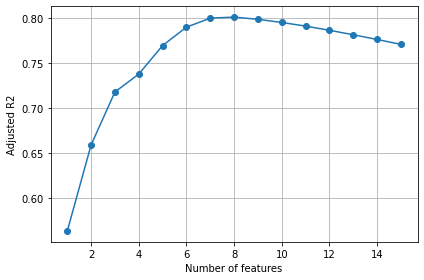

[0.7704326185702661, 0.7758985086043074, 0.781110171194905, 0.7860751584445018, 0.7907089696611456, 0.7947418414253992, 0.7982267668912928, 0.8006845427969339, 0.7995230515267383, 0.7895398061738809, 0.7691727730771459, 0.7375514409108018, 0.7176954068919048, 0.6589776575136159, 0.5635191948813649]


In [9]:
# Plot the trend of adjusted R2 variation as features are eliminated
k_features = [len(k) for k in sbs.subsets_]
plt.plot(k_features, sbs.scores_, marker='o')
#plt.ylim([0.7, 1.02])
plt.ylabel('Adjusted R2')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()
print(sbs.scores_)

In [10]:
# Display details of best combination identified based on best Adjusted R2 score
bestScore,bestIndices, removedIndices=sbs.fetchBestScoreDetails(x_train)
print('Best Adjusted R2: ', bestScore, '\n')
print('Optimal Features Size: ', bestIndices.size, '\n')
print('Optimal Features: ', bestIndices.values, '\n')
print('Removed Features: ', removedIndices, '\n')


Best Adjusted R2:  0.8006845427969339 

Optimal Features Size:  8 

Optimal Features:  ['Distance' 'Status' 'Cost' 'Discount' 'PureVeg' 'PromoCode_PRO'
 'PaymentMode_WALLET' 'Membership_BING'] 

Removed Features:  Index(['Membership_BONG', 'Membership_NO', 'MinutesToDeliver',
       'PaymentMode_COD', 'PromoCode_BF', 'Surge charges', 'Tip'],
      dtype='object') 



In [11]:
# Drop the features as identified by backward step-wise elimination alogrithm
X_normalized=X_normalized.drop(removedIndices, axis=1)
X_normalized.shape

(57, 9)

In [12]:
# function to randomly split data into training and testing sets - 65-35 split done here as total data size is too low
def splitData(X,Y):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.35, random_state = 100)
    y_train=y_train.to_numpy().reshape(-1,1)
    y_train=pd.DataFrame(y_train,columns=['Rating'])
    y_test=y_test.to_numpy().reshape(-1,1)
    y_test=pd.DataFrame(y_test,columns=['Rating'])
    return x_train, x_test, y_train, y_test

In [13]:
X=X_normalized.copy()
X,Y = splitFeaturesTarget(X_normalized,'Rating')
print('X Shape: ', X.shape)
print('Y Shape: ', Y.shape)
x_train, x_test, y_train, y_test = splitData(X,Y)
print('x_train Shape: ', x_train.shape)
print('x_test Shape: ', x_test.shape)
print('y_train Shape: ', y_train.shape)
print('y_test Shape: ', y_test.shape)





X Shape:  (57, 8)
Y Shape:  (57, 1)
x_train Shape:  (37, 8)
x_test Shape:  (20, 8)
y_train Shape:  (37, 1)
y_test Shape:  (20, 1)


In [14]:
# Fit the linear regression model with reduced feature set and training data
reg.fit(x_train,y_train)
# Predict on testing set using the trained linear regression model 
y_pred = reg.predict(x_test)

# Calculate the key performance metrics of the model
Adj_r2 = 1 - ((1-r2_score(y_test, y_pred)) * (len(y_test)-1)/(len(y_test)-x_test.shape[1]-1))
print('Adjusted R2 score: ',Adj_r2)
mse=mean_squared_error(y_test,y_pred)
rmse=np.sqrt(mse)
print('MSE: ', mse)
print('RMSE: ', rmse)

Adjusted R2 score:  0.7195591262235568
MSE:  0.013248617279038708
RMSE:  0.11510263801945943


# Approach 2

In [455]:
swiggyToDataSet = pd.read_excel("Temp2.xlsx")
swiggyToDataSet.head()

,Distance,Status,Cost,Discount,Surge charges,Tip,PureVeg,Rating,MinutesToDeliver,PromoCode_BF,PromoCode_PRO,PaymentMode_COD,PaymentMode_WALLET,Membership_BING,Membership_BONG,Membership_NO
0,3,1,300,50,0,0,1,2,60,0,1,1,0,1,0,0
1,3,1,100,0,0,5,0,4,20,1,0,0,1,0,1,0
2,6,0,250,25,10,5,1,0,30,0,1,0,0,1,0,0
3,4,1,550,0,10,0,0,1,95,0,1,1,0,0,0,1
4,3,0,125,0,0,0,1,1,60,0,1,1,0,0,0,1


In [456]:
X_normalized=normalizeData(swiggyToDataSet)
X,Y = splitFeaturesTarget(X_normalized,'Rating')
print('X Shape: ', X.shape)
print('Y Shape: ', Y.shape)

X Shape:  (57, 15)
Y Shape:  (57, 1)


In [27]:
# Define lists to store info from every iteration
fcount=[]
mseArr=[]
fNames=[]
ar2=[]
# iterate till all features are reduced
count=0
for i in reversed(range(1,X.shape[1]+1)):
    print('--------------------------------------------------------------------------------------------------------------')
    count+=1
    print('Iteration: ', count)
    print('--------------------------------------------------------------------------------------------------------------')
    lreg = LinearRegression()
    # define the backward selector using MSE as the scoring factor
    sfs1 = sfs(lreg, k_features=i, forward=False, verbose=0, scoring='neg_mean_squared_error')
    # fit the model using full data set
    sfs1 = sfs1.fit(X, Y)
    feat_names = list(sfs1.k_feature_names_)
    fNames.append(feat_names)
    print('Selected Features: ', feat_names,'\n')
    print('Selected Features Count: ', len(feat_names),'\n')
    fcount.append(len(feat_names))
    # get the reduced dataset
    new_data = X_normalized[feat_names]
    # split into training and testing sets
    x_train, x_test, y_train, y_test = splitData(new_data,Y)
    
    # fit the model with training set on reduced features
    lreg.fit(x_train,y_train)
    # predict testing set using trained model
    y_pred=lreg.predict(x_test)
    # Calculate key model performance metrics based on predictions on testing set
    score = 1 - ((1-r2_score(y_test, y_pred)) * (len(y_test)-1)/(len(y_test)-x_test.shape[1]-1))
    print('Adjusted R2: ', score, '\n')
    ar2.append(score)
    mse=mean_squared_error(y_test,y_pred)
    rmse=np.sqrt(mse)
    print('MSE: ', mse, '\n')
    mseArr.append(mse)
    print('RMSE: ', rmse, '\n')

--------------------------------------------------------------------------------------------------------------
Iteration:  1
--------------------------------------------------------------------------------------------------------------
Selected Features:  ['Distance', 'Status', 'Cost', 'Discount', 'Surge charges', 'Tip', 'PureVeg', 'MinutesToDeliver', 'PromoCode_BF', 'PromoCode_PRO', 'PaymentMode_COD', 'PaymentMode_WALLET', 'Membership_BING', 'Membership_BONG', 'Membership_NO'] 

Selected Features Count:  15 

Adjusted R2:  -0.4491133849582598 

MSE:  0.024894242571072422 

RMSE:  0.15777909421426028 

--------------------------------------------------------------------------------------------------------------
Iteration:  2
--------------------------------------------------------------------------------------------------------------
Selected Features:  ['Distance', 'Status', 'Cost', 'Discount', 'Tip', 'PureVeg', 'MinutesToDeliver', 'PromoCode_BF', 'PromoCode_PRO', 'PaymentMode_COD', '

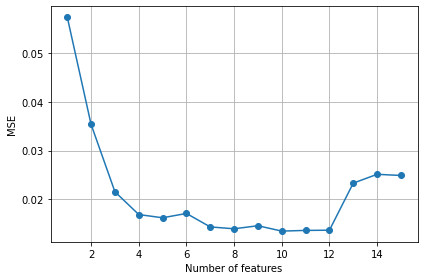

[0.024894242571072422, 0.02513282682954212, 0.023318873737505488, 0.013664084222088554, 0.01362413648856745, 0.013481922623553183, 0.014581814883262123, 0.013957941540644026, 0.014336754867645938, 0.017103690682009728, 0.016214315513875473, 0.016879067806214936, 0.02155362072190632, 0.03536748480589458, 0.057384527220034884]


In [28]:
# Plot the trend of MSE variation as features are eliminated

plt.plot(fcount, mseArr, marker='o')
#plt.ylim([0.7, 1.02])
plt.ylabel('MSE')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()
print(mseArr)

In [465]:
# Display details of best combination identified based on least MSE
index=mseArr.index(np.min(mseArr))
print('Optimal Features Size: ', fcount[index], '\n')
print('Optimal Features: ', fNames[index], '\n')
print('Removed Features: ', set (X.columns).difference(fNames[index]), '\n')
print('Adjusted R2: ', ar2[index], '\n')
print('MSE: ',  mseArr[index], '\n')
print('RMSE: ',  np.sqrt(mseArr[index]), '\n')


Optimal Features Size:  10 

Optimal Features:  ['Distance', 'Status', 'Cost', 'Discount', 'Tip', 'PureVeg', 'MinutesToDeliver', 'PaymentMode_WALLET', 'Membership_BING', 'Membership_NO'] 

Removed Features:  {'PromoCode_BF', 'Surge charges', 'Membership_BONG', 'PromoCode_PRO', 'PaymentMode_COD'} 

Adjusted R2:  0.6512029822337819 

MSE:  0.013481922623553192 

RMSE:  0.11611168168428701 



In [15]:
swiggyToDataSet = pd.read_excel("Temp2.xlsx")
swiggyToDataSet.head()

,Distance,Status,Cost,Discount,Surge charges,Tip,PureVeg,Rating,MinutesToDeliver,PromoCode_BF,PromoCode_PRO,PaymentMode_COD,PaymentMode_WALLET,Membership_BING,Membership_BONG,Membership_NO
0,3,1,300,50,0,0,1,2,60,0,1,1,0,1,0,0
1,3,1,100,0,0,5,0,4,20,1,0,0,1,0,1,0
2,6,0,250,25,10,5,1,0,30,0,1,0,0,1,0,0
3,4,1,550,0,10,0,0,1,95,0,1,1,0,0,0,1
4,3,0,125,0,0,0,1,1,60,0,1,1,0,0,0,1


In [16]:
X_normalized=normalizeData(swiggyToDataSet)
X,Y = splitFeaturesTarget(X_normalized,'Rating')
print('X Shape: ', X.shape)
print('Y Shape: ', Y.shape)

X Shape:  (57, 15)
Y Shape:  (57, 1)


In [17]:
poly = PolynomialFeatures(degree=3)
modified_X = poly.fit_transform(X)

In [18]:
modified_X

array([[1.  , 0.25, 1.  , ..., 0.  , 0.  , 0.  ],
       [1.  , 0.25, 1.  , ..., 0.  , 0.  , 0.  ],
       [1.  , 1.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [1.  , 0.5 , 1.  , ..., 0.  , 0.  , 0.  ],
       [1.  , 0.25, 0.  , ..., 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [19]:
x_train, x_test, y_train, y_test = splitData(modified_X,Y)
print('x_train Shape: ', x_train.shape)
print('x_test Shape: ', x_test.shape)
print('y_train Shape: ', y_train.shape)
print('y_test Shape: ', y_test.shape)

x_train Shape:  (37, 816)
x_test Shape:  (20, 816)
y_train Shape:  (37, 1)
y_test Shape:  (20, 1)


In [20]:
reg = LinearRegression()
reg.fit(x_train,y_train)

LinearRegression()

In [21]:
# Predict on testing set using the trained linear regression model 
y_pred = reg.predict(x_test)

# Calculate the key performance metrics of the model
Adj_r2 = 1 - ((1-r2_score(y_test, y_pred)) * (len(y_test)-1)/(len(y_test)-x_test.shape[1]-1))
print('Adjusted R2 score: ',Adj_r2)
mse=mean_squared_error(y_test,y_pred)
rmse=np.sqrt(mse)
print('MSE: ', mse)
print('RMSE: ', rmse)

Adjusted R2 score:  1.0808540813873124
MSE:  0.27675586072842834
RMSE:  0.5260759077627756


In [22]:
# Predict on training set using the trained linear regression model 
y_pred_train = reg.predict(x_train)

# Calculate the key performance metrics of the model
Adj_r2 = 1 - ((1-r2_score(y_train, y_pred_train)) * (len(y_train)-1)/(len(y_train)-x_train.shape[1]-1))
print('Adjusted R2 score: ',Adj_r2)
mse=mean_squared_error(y_train,y_pred_train)
rmse=np.sqrt(mse)
print('MSE: ', mse)
print('RMSE: ', rmse)

Adjusted R2 score:  1.0015682888540032
MSE:  0.004864864864864866
RMSE:  0.06974858324629157


X Shape:  (57, 15)
Y Shape:  (57, 1)
Training Points:  37
Testing Points:  20


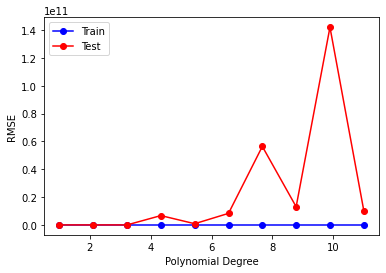

In [25]:
swiggyToDataSet = pd.read_excel("Temp2.xlsx")
swiggyToDataSet.head()
X_normalized=normalizeData(swiggyToDataSet)
X,Y = splitFeaturesTarget(X_normalized,'Rating')
print('X Shape: ', X.shape)
print('Y Shape: ', Y.shape)
train_err = []
test_err = []

for i in range(1,11):
    poly = PolynomialFeatures(degree=i)
    modified_X = poly.fit_transform(X)
    x_train, x_test, y_train, y_test = splitData(modified_X,Y)
    if i==1:
        print('Training Points: ', x_train.shape[0])
        print('Testing Points: ', x_test.shape[0])
    reg = LinearRegression()
    reg.fit(x_train,y_train)
    y_pred_train = reg.predict(x_train)
    mse=mean_squared_error(y_train,y_pred_train)    
    train_err.append(np.sqrt(mse))
    y_pred = reg.predict(x_test)
    mse_test=mean_squared_error(y_test,y_pred)
    test_err.append(np.sqrt(mse_test))
plt.xlabel('Polynomial Degree')
plt.ylabel('RMSE')
plt.plot(np.linspace(1,11,10),train_err, 'bo-',label='Train')
plt.plot(np.linspace(1,11,10),test_err, 'ro-',label='Test')
plt.legend()
plt.show()   